In [16]:
import hnswlib
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import scipy.sparse
from modules import network,mlp
from utils import yaml_config_hook,save_model
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [3]:
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569, 2000) (8569, 1)


,2,10,13,41,45,62,68,106,133,147,...,19763,19786,19808,19854,19883,20021,20073,20109,20121,20124
0,0.0,1.302199,0.0,0.0,0.0,0.000000,0.36896,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.637877,0.368960
1,0.0,1.351171,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.888292,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.711146,0.00000,0.0,0.0,0.0,...,0.0,0.417500,0.0,0.0,0.93785,0.0,0.0,0.0,0.937850,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.509045,0.00000,0.0,0.0,0.0,...,0.0,0.509045,0.0,0.0,0.00000,0.0,0.0,0.0,0.509045,0.509045


In [4]:
from torch.utils.data import DataLoader,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

# scTrainLength = int(len(scDataset) * 0.8)
# scValidLength = len(scDataset) - scTrainLength
# scTrain, scValid = random_split(scDataset, [scTrainLength, scValidLength])

scDataLoader = DataLoader(scDataset, shuffle=False, batch_size=args.batch_size,drop_last=True)
# scValidDataLoader = DataLoader(scValid, shuffle=True, batch_size=256,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

2000
1024
1024


In [22]:
index=np.where(y_ndarray.squeeze()==8)
# print(index)
x_8 =x_ndarray[index]
print(x_8.shape)
# print(x_8)

(18, 2000)


In [32]:
num_elements=len(scDataset)
n=hnswlib.Index(space='cosine',dim=args.num_genes)
n.init_index(max_elements=num_elements, ef_construction=100, M=16)
n.set_ef(100)
n.set_num_threads(4)
n.add_items(x_ndarray)

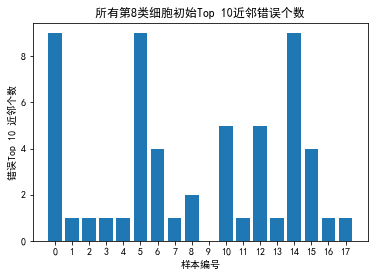

In [47]:
incorrect_8=[]
for i in x_8:
    label,distance=n.knn_query(i,k=10)
    incorrect=np.where(y_ndarray[label.squeeze()]!=8)[0].shape[0]
    incorrect_8.append(incorrect)
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.bar(x=np.arange(len(incorrect_8)),height=incorrect_8)
plt.xticks(np.arange(len(incorrect_8)))
plt.xlabel('样本编号')
plt.ylabel('错误Top 10 近邻个数')
plt.title('所有第8类细胞初始Top 10近邻错误个数')
plt.show()

In [63]:
mlp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp, args.feature_dim, args.classnum)
model = model.to('cuda')

In [6]:
from sklearn.manifold import TSNE



checkpoint = torch.load('save\sc-no-bank-drop2\checkpoint_498.tar')
model.load_state_dict(checkpoint['net'])
x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
print(embeddings.shape)
embeddings=embeddings.detach().cpu().numpy()

torch.Size([8569, 128])


In [8]:
print(y_ndarray[0])

[1]


In [9]:
incorrect_list=np.zeros(args.classnum+1)
for step,(features,psedulabels) in enumerate(scDataLoader):
    # print(features.shape,psedulabels.shape)
    test_sample=model.forward_embedding(features.to('cuda')).detach().cpu().numpy()

    sample,labell=n.knn_query(test_sample,10)
    # print(sample.shape,labell.shape)
    for no,zipped in enumerate(zip(sample,labell)):
        # print(step*args.batch_size+no)
        # print(y_ndarray[step*args.batch_size+no])
        # print(y_ndarray[zipped[0]])
        a=y_ndarray[zipped[0]]
        # print(zipped[1])
        wrong=a[a!=y_ndarray[step*args.batch_size+no]].size
        incorrect_list[y_ndarray[step*args.batch_size+no]]+=wrong

15
[0.         0.01367432 0.0415493  0.00993121 0.01580198 0.0437604
 0.01030641 0.01904762 0.44444444 0.0572549  0.03454545 0.108
 0.11213873 0.10769231 0.62857143]


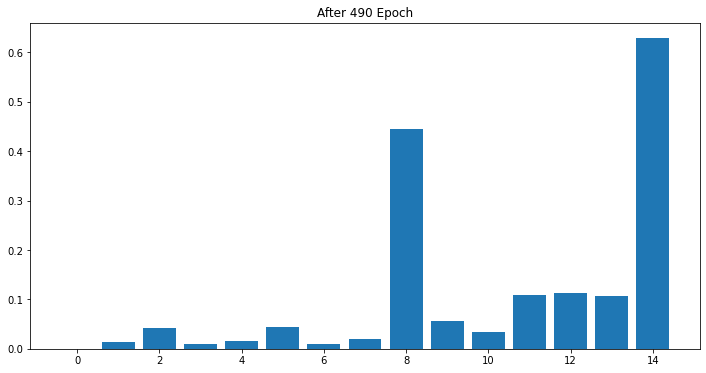

In [10]:
from matplotlib import pyplot as plt
print(len(incorrect_list))
for i in range(1,len(incorrect_list)):
    incorrect_list[i]/=(sum(y_ndarray==i)*10)
plt.figure(figsize=(12, 6))
plt.bar(x=np.arange(0,len(incorrect_list)),height=incorrect_list)
print(incorrect_list)
plt.title('After 490 Epoch')
plt.show()

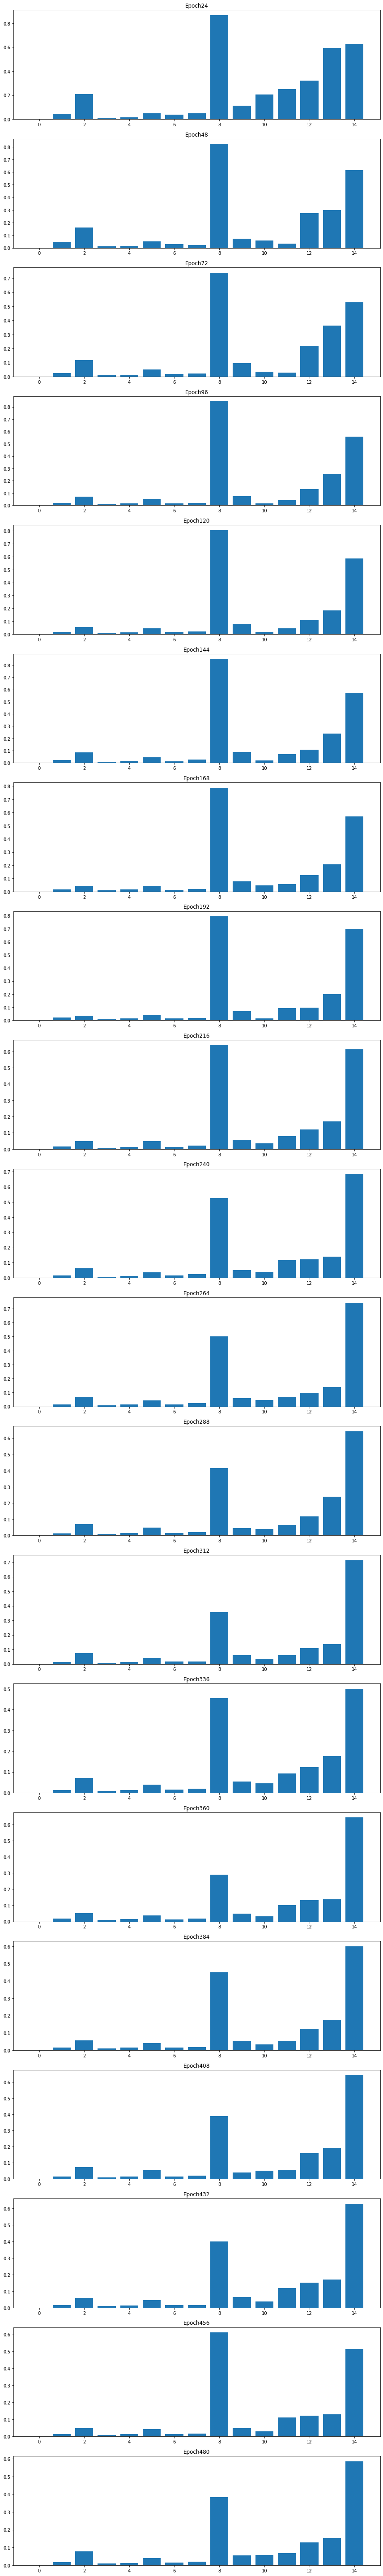

In [28]:
i=5

# plt.subplots_adjust(top=0.85)
# plt.suptitle('Result')
# plt.show()

f, ax = plt.subplots(nrows=20, ncols=1, figsize=(12, 80))
for k in range(20):
    checkpoint = torch.load('save\sc-no-bank-drop2\checkpoint_'+str(24*(k+1))+'.tar')
    model.load_state_dict(checkpoint['net'])
    x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
    embeddings=model.forward_embedding(x)
    # print(embeddings.shape)
    embeddings=embeddings.detach().cpu().numpy()
    num_elements=len(scDataset)
    dim=high_var_gene
    n=hnswlib.Index(space='l2',dim=128)
    n.init_index(max_elements=num_elements, ef_construction=100, M=16)
    n.set_ef(100)
    n.set_num_threads(4)
    n.add_items(embeddings)
    incorrect_list=np.zeros(args.classnum+1)
    for step,(features,psedulabels) in enumerate(scDataLoader):
        test_sample=model.forward_embedding(features.to('cuda')).detach().cpu().numpy()

        sample,labell=n.knn_query(test_sample,10)
        for no,zipped in enumerate(zip(sample,labell)):
            a=y_ndarray[zipped[0]]
            wrong=a[a!=y_ndarray[step*args.batch_size+no]].size
            incorrect_list[y_ndarray[step*args.batch_size+no]]+=wrong
    for i in range(1,len(incorrect_list)):
        incorrect_list[i]/=(sum(y_ndarray==i)*10)
    
    ax[k].bar(x=np.arange(len(incorrect_list)),height=incorrect_list)
    ax[k].set_title('Epoch'+str(24*(k+1)))
plt.tight_layout()
plt.show()

In [55]:
total_list=[]
for k in range(20):
    checkpoint = torch.load('save\sc-no-bank-drop2\checkpoint_'+str(24*(k+1))+'.tar')
    model.load_state_dict(checkpoint['net'])
    x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
    embeddings=model.forward_embedding(x)
    embeddings=embeddings.detach().cpu().numpy()

    num_elements=len(scDataset)
    dim=high_var_gene
    n=hnswlib.Index(space='l2',dim=128)
    n.init_index(max_elements=num_elements, ef_construction=100, M=16)
    n.set_ef(100)
    n.set_num_threads(4)
    n.add_items(embeddings)
    incorrect_list=np.zeros(args.classnum+1)
    for step,(features,psedulabels) in enumerate(scDataLoader):
        test_sample=model.forward_embedding(features.to('cuda')).detach().cpu().numpy()

        sample,labell=n.knn_query(test_sample,10)
        for no,zipped in enumerate(zip(sample,labell)):
            a=y_ndarray[zipped[0]]
            wrong=a[a!=y_ndarray[step*args.batch_size+no]].size
            incorrect_list[y_ndarray[step*args.batch_size+no]]+=wrong
    for i in range(1,len(incorrect_list)):
        incorrect_list[i]/=(sum(y_ndarray==i)*10)
    total_list.append(incorrect_list)

print(np.array(total_list).shape)
    

(20, 15)


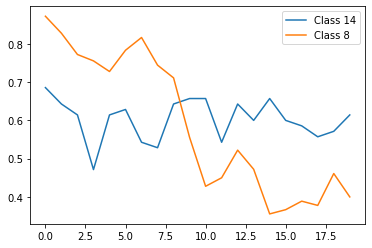

In [58]:
# print(total_list)
# for step,i in enumerate(total_list):
#     eight_wrong=[]
#     print(step,i.shape)
#     eight_wrong.append(i[step-1])
#     plt.plot(np.array(eight_wrong))
eight_list=[]
forteen_list=[]
for i in range(20):
    forteen_list.append(total_list[i][14])
    eight_list.append(total_list[i][8])
plt.plot(forteen_list,label='Class 14')
plt.plot(eight_list,label='Class 8')
plt.legend()
plt.show()

55


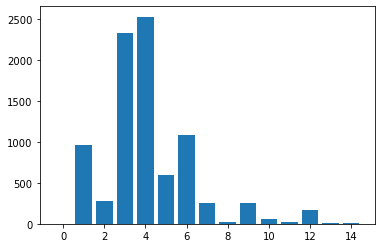

In [13]:
y_8=y_ndarray[y_ndarray==10]
print(y_8.size)

y_count=np.zeros(args.classnum+1)
for i in range (0,args.classnum):
    y_count[i+1]=y_ndarray[y_ndarray==(i+1)].size

plt.bar(x=np.arange(0,len(y_count)),height=y_count)
plt.show()

In [ ]:
distances=[]
for i in x_ndarray:
    indexes,distance=p.knn_query(i,k=11)
    distance=np.array(distance)
    distances.append(np.squeeze(distance))




In [ ]:
print(len(distances[0]))
distances=np.array(distances)
max_data=np.amax(distances,axis=1)
print(max_data.shape)

11
(8569,)


In [ ]:
np.percentile(distances,90)

0.42384552955627436

In [ ]:
distances.max(),distances.mean(),max_data.min()

(0.6849649, 0.29636806, 0.09975737)

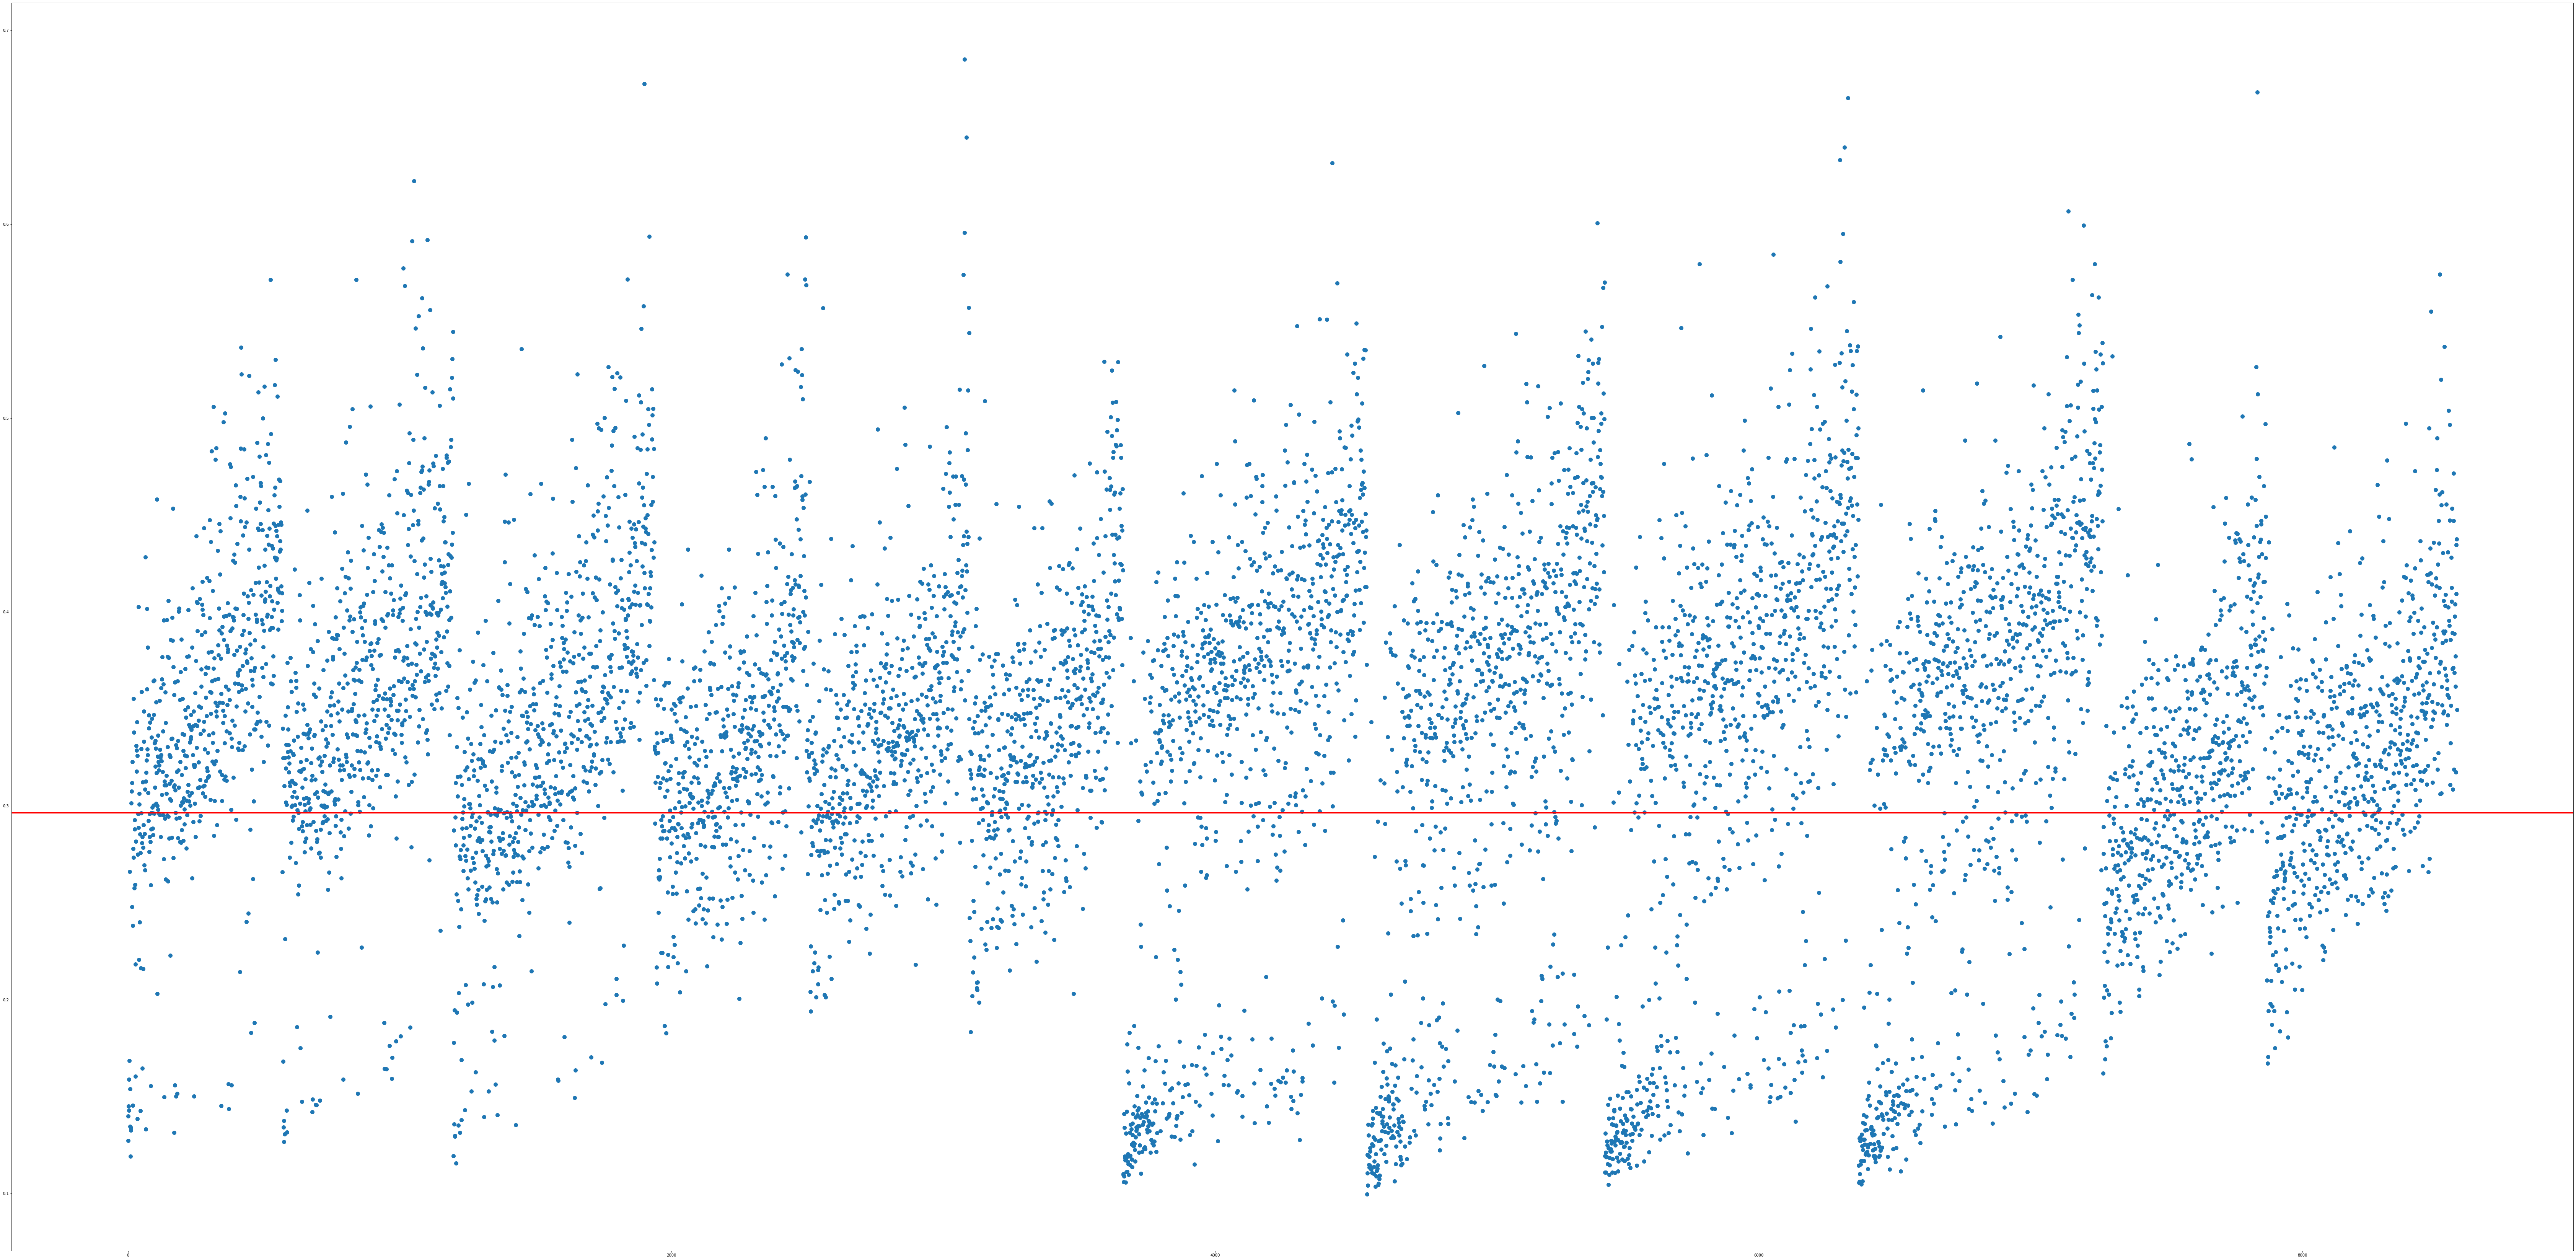

In [ ]:
from matplotlib import pyplot as plt
x_data=np.arange(start=0,stop=len(max_data))
plt.figure(figsize=(120, 60))
plt.scatter(x=x_data,y=max_data,s=100)
plt.axhline(distances.mean(),color='red',linewidth=4)
plt.show()

In [5]:
from sklearn.manifold import TSNE

mlp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp, args.feature_dim, args.classnum)
model = model.to('cuda')

checkpoint = torch.load('save\sc-no-bank-drop2\checkpoint_30.tar')
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [6]:
x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
print(embeddings.shape)

torch.Size([8569, 128])


In [7]:
embeddings=embeddings.detach().cpu().numpy()

In [8]:
X_tsne = TSNE(n_components=2,random_state=24).fit_transform(embeddings)

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Epoch 9 with KMeans predict label')

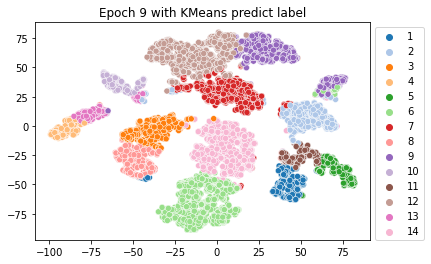

In [20]:
import seaborn as sns
palette = sns.color_palette("tab20", args.classnum)
ax=sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=results["kmeans_pred"]+1, legend='full',palette=palette)
sns.move_legend(ax,"upper left", bbox_to_anchor=(1, 1))
ax.set_title('Epoch 9 with KMeans predict label')

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Epoch 9 with Leiden predict label')

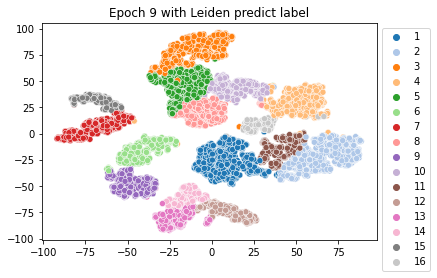

In [45]:
palette = sns.color_palette("tab20", len(np.unique(results["leiden_pred"])))
ax=sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=np.array(results["leiden_pred"])+1, legend='full',palette=palette)
sns.move_legend(ax,"upper left", bbox_to_anchor=(1, 1))
ax.set_title('Epoch 9 with Leiden predict label')

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Epoch 9 with true label')

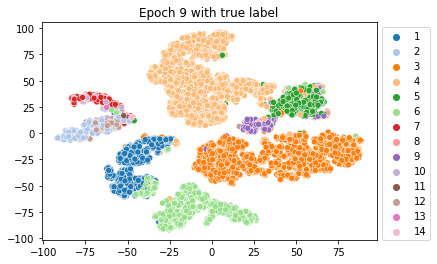

In [46]:
palette = sns.color_palette("tab20", args.classnum)
ax=sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=y, legend='full',palette=palette)
sns.move_legend(ax,"upper left", bbox_to_anchor=(1, 1))
ax.set_title('Epoch 9 with true label')

In [9]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (adjusted_rand_score, calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)


In [10]:
def run_leiden(data, leiden_n_neighbors=300):
    """
    Performs Leiden community detection on given data.

    Args:
        data ([type]): [description]
        n_neighbors (int, optional): [description]. Defaults to 10.
        n_pcs (int, optional): [description]. Defaults to 40.

    Returns:
        [type]: [description]
    """
    import scanpy as sc
    n_pcs=0
    adata = sc.AnnData(data)
    sc.pp.neighbors(adata, n_neighbors=leiden_n_neighbors, n_pcs=n_pcs, use_rep='X')
    sc.tl.leiden(adata)
    pred = adata.obs['leiden'].to_list()
    pred = [int(x) for x in pred]
    return pred

In [11]:
def cluster_embedding(embedding, cluster_number, Y, save_pred = False, 
                      leiden_n_neighbors=300, cluster_methods =["KMeans", "Leiden"]):
    """[summary]

    Args:
        embedding ([type]): [description]
        cluster_number ([type]): [description]
        Y ([type]): [description]
        save_pred (bool, optional): [description]. Defaults to False.
        leiden_n_neighbors (int, optional): [description]. Defaults to 300.

    Returns:
        [type]: [description]
    """
    result = {}
    if "KMeans" in cluster_methods:
        # evaluate K-Means
        kmeans = KMeans(n_clusters=cluster_number,
                        init="k-means++",
                        random_state=0)
        pred = kmeans.fit_predict(embedding)
        if Y is not None:
            result[f"kmeans_ari"] = adjusted_rand_score(Y, pred)
            result[f"kmeans_nmi"] = normalized_mutual_info_score(Y, pred)
        result[f"kmeans_sil"] = silhouette_score(embedding, pred)
        result[f"kmeans_cal"] = calinski_harabasz_score(embedding, pred)
        if save_pred:
            result[f"kmeans_pred"] = pred
    if "Leiden" in cluster_methods:
    # evaluate leiden
        pred = run_leiden(embedding, leiden_n_neighbors)

        if Y is not None:
            result[f"leiden_ari"] = adjusted_rand_score(Y, pred)
            result[f"leiden_nmi"] = normalized_mutual_info_score(Y, pred)
        result[f"leiden_sil"] = silhouette_score(embedding, pred)
        result[f"leiden_cal"] = calinski_harabasz_score(embedding, pred)
        if save_pred:
            result[f"leiden_pred"] = pred

    return result

In [12]:
results=cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,Y=y_ndarray.squeeze(),save_pred=True)

In [14]:
print(results['kmeans_ari'])
print(results['kmeans_nmi'])
print(results['kmeans_sil'])
print(results['kmeans_cal'])
print(results['kmeans_pred'])
print('================================')
print(results['leiden_ari'])
print(results['leiden_nmi'])
print(results['leiden_sil'])
print(results['leiden_cal'])
# print(results['leiden_pred'])

0.5054424923145474
0.721674152168604
0.4101485
7969.1323015979315
[ 7  7  2 ... 11 11  7]
0.4467042852057097
0.7379493194350566
0.35024342
5993.3532909855085


In [21]:
def embedding_cluster_visualization(embeddings,result,true_label,args,epoch):
    X_tsne = TSNE(n_components=2,random_state=24).fit_transform(embeddings)
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    palette_0 = sns.color_palette("tab20", args.classnum)
    axs=sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=result["kmeans_pred"]+1, legend='full',palette=palette_0,ax=ax[0])
    sns.move_legend(ax[0],"upper left", bbox_to_anchor=(1, 1))
    axs.set_title(f'Epoch {epoch} with KMeans predict label\n'+f"ARI:{round(result['kmeans_ari'], 2)}  "+f"NMI:{round(float(result['kmeans_nmi']),2)} ")

    palette_1 = sns.color_palette("tab20", len(np.unique(result["leiden_pred"])))
    axs=sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=np.array(result["leiden_pred"])+1, legend='full',palette=palette_1,ax=ax[1])
    sns.move_legend(ax[1],"upper left", bbox_to_anchor=(1, 1))
    axs.set_title(f'Epoch {epoch} with Leiden predict label\n'+f"ARI:{round(result['leiden_ari'], 2)}  "+f"NMI:{round(float(result['leiden_nmi']),2)} ")

    axs=sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=true_label, legend='full',palette=palette_0,ax=ax[2])
    sns.move_legend(ax[2],"upper left", bbox_to_anchor=(1, 1))
    axs.set_title(f'Epoch {epoch} with true label')

    plt.show()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

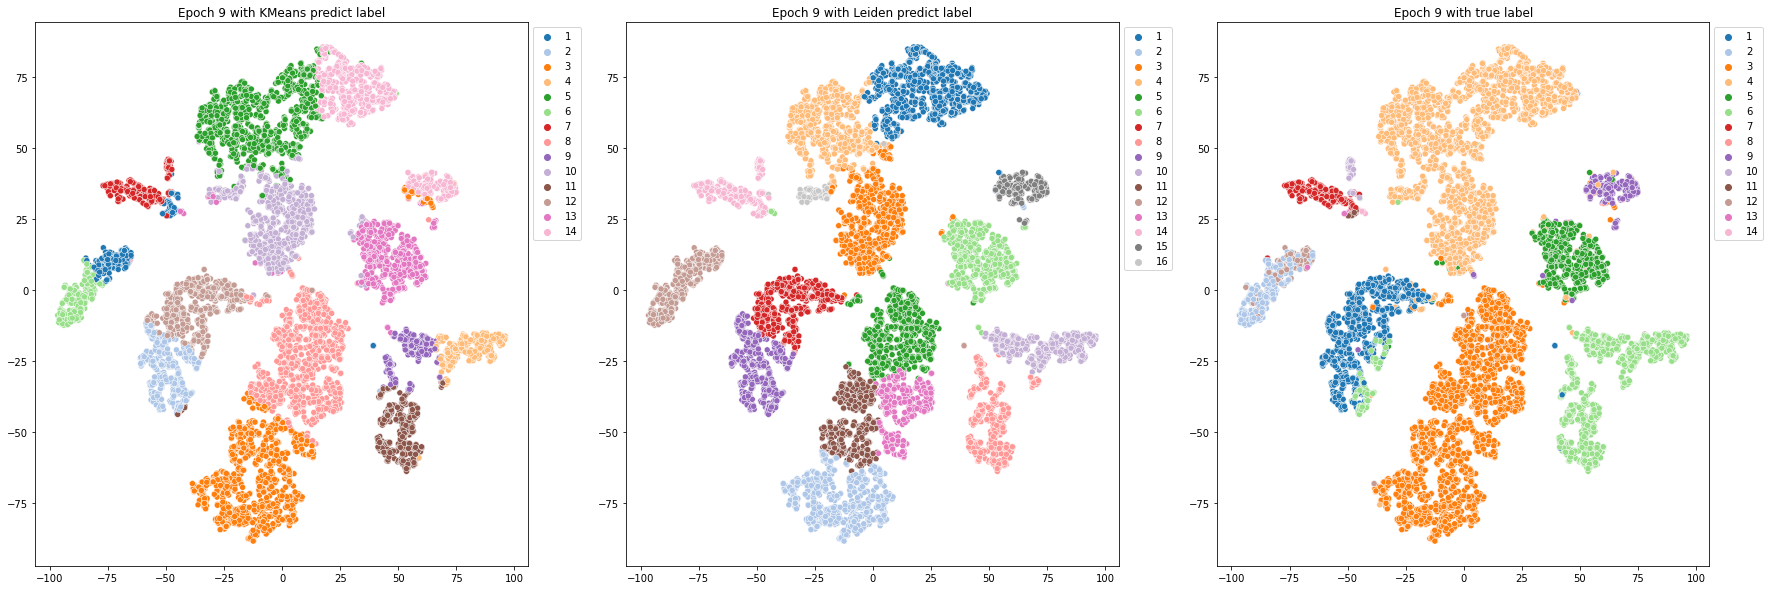

In [17]:
from matplotlib import pyplot as plt

X_tsne = TSNE(n_components=2,random_state=24).fit_transform(embeddings)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
palette_0 = sns.color_palette("tab20", args.classnum)
axs=sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=results["kmeans_pred"]+1, legend='full',palette=palette_0,ax=ax[0])
sns.move_legend(ax[0],"upper left", bbox_to_anchor=(1, 1))
axs.set_title(f'Epoch 9 with KMeans predict label')

palette_1 = sns.color_palette("tab20", len(np.unique(results["leiden_pred"])))
axs=sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=np.array(results["leiden_pred"])+1, legend='full',palette=palette_1,ax=ax[1])
sns.move_legend(ax[1],"upper left", bbox_to_anchor=(1, 1))
axs.set_title(f'Epoch 9 with Leiden predict label')

axs=sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=y, legend='full',palette=palette_0,ax=ax[2])
sns.move_legend(ax[2],"upper left", bbox_to_anchor=(1, 1))
axs.set_title(f'Epoch 9 with true label')

plt.show()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

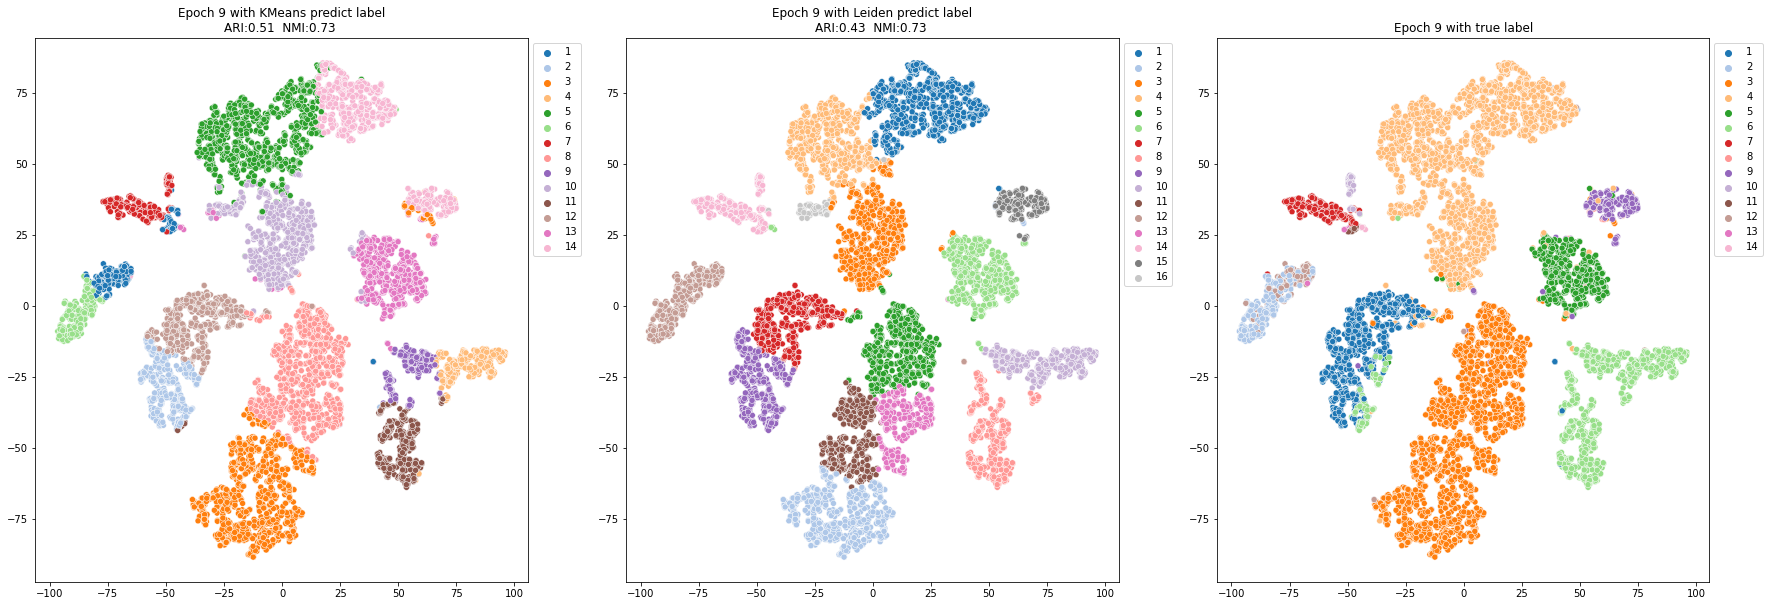

In [22]:
embedding_cluster_visualization(embeddings,results,y,args,9)

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


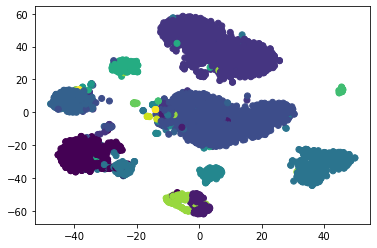

In [ ]:
X_tsne = TSNE(n_components=2,random_state=33).fit_transform(x_ndarray)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_ndarray,label="t-SNE")

In [ ]:
mlp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [ ]:
for features,psedulabels in scDataLoader:
    

    labels, distances = p.knn_query(x_ndarray[0], k=64)
    # print(labels,distances)
    print(distances.shape)
    print(distances[0][-1])
    print(type(labels))
    labels=labels.squeeze()
    # print(labels)

    contrastive=features[labels.tolist()]
    print(contrastive.shape)


    input=np.row_stack((contrastive,x_ndarray[0]))
    # print(input.shape)
    input_1=input.copy()
    np.random.shuffle(input)

    input=torch.from_numpy(input).to('cuda')
    input_1=torch.from_numpy(input_1).to('cuda')

    print(model(input))
    print(model(input_1))
    print(input.shape,input_1.shape)
    
    break

(1, 64)
396.69873
<class 'numpy.ndarray'>
torch.Size([64, 3000])


TypeError: forward() missing 1 required positional argument: 'x_j'